In [88]:
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain

## Getting Genre/Partition dictionaries

In [2]:
## Dictionary with Movie as Key and Genre as Value
# code taken from Group Project MWRP.ipynb because the import of this dictionary takes a long time

data_for_clusters =  pd.read_csv("10%Dataset.csv") 
data_for_clusters = data_for_clusters[["Movie", "MovieGenre"]]
dataclusters = data_for_clusters.drop_duplicates().reset_index(drop=True)

keys = dataclusters["Movie"]
values = dataclusters["MovieGenre"]

dict_mvs_genre = dict(zip(keys, values))
print(dict_mvs_genre)

{'B000NDFLWG': 'Documentary', 'B008FPU7AA': 'Horror', '1562229567': 'Documentary', '1888617047': 'Musicals', '6305508569': 'Action', '6304474415': 'Documentary', 'B0006FFRD4': 'Anime & Manga', 'B003BUAP10': 'Documentary', 'B000BB1NFO': 'Documentary', 'B00020HBN2': 'Anime & Manga', 'B000GAKJXM': 'Documentary', 'B00020HBNW': 'Anime & Manga', 'B00020HBNC': 'Anime & Manga', 'B0012EM5GK': 'Anime & Manga', 'B0002V7TJM': 'Documentary', 'B0002V7TJC': 'Documentary', 'B00004R7CH': 'Musicals', 'B0002V7TJW': 'Documentary', 'B00000IC80': 'Musicals', '6300246299': 'Horror', 'B00000IC8F': 'Musicals', 'B0014567LQ': 'Horror', 'B001DWNUBU': 'Documentary', 'B008R52L4I': 'Horror', 'B000H5U5IU': 'Horror', 'B000VZC4XA': 'Horror', 'B0071BY2YQ': 'Documentary', '0764004492': 'Horror', 'B006HNRSFE': 'Documentary', 'B0007M21Y4': 'Musicals', '6300266850': 'Horror', 'B000KGGJ04': 'Action', 'B000A9QK8M': 'Action', 'B003ZZ7TT2': 'Musicals', 'B000FP2PE4': 'Documentary', '6304462689': 'Documentary', 'B004J0DQS0': 'Doc

In [3]:
# Amount of different movies
print(len(dict_mvs_genre))

21788


In [81]:
# Importing the weighted network to modify
G = nx.read_weighted_edgelist('10%Network.csv')

In [ ]:
# Importing the weighted network to NOT modify
CG = nx.read_weighted_edgelist('10%Network.csv')

### 1.1 Experimenting with removing low weights

In [28]:
# List of all links of the network, including their weight 
all_edges = list(G.edges.data())
all_edges[0]

('B000NDFLWG', '6305804427', {'weight': 1.0})

In [29]:
# List of all links with only 1 as weight
one_weight = [tpl for tpl in all_edges if tpl[2]["weight"] == 1.0]

In [8]:
# Comparing the total amount of edges and number of edges with weight 1
# Over half of the edges have only weight 1 (only one person liked both movies together)
print("Total amount of edges:", len(all_edges))
print("Amount of edges with weight 1:", len(one_weight))

Total amount of edges: 4174006
Amount of edges with weight 1: 2756884


In [30]:
# We remove from the network all edges with weight one
G.remove_edges_from(one_weight)

In [31]:
# Get the weighted degrees of all nodes
all_degrees = list(G.degree(weight="weight"))
all_degrees[:5]

[('B000NDFLWG', 20.0),
 ('6305804427', 0),
 ('B0001IXT36', 339.0),
 ('B000EOTEIQ', 0),
 ('B000ARFPV2', 0)]

In [32]:
# Sort films by ascending degree (with weights)
all_degrees.sort(key=lambda x: x[1])
all_degrees[:5]

[('6305804427', 0),
 ('B000EOTEIQ', 0),
 ('B000ARFPV2', 0),
 ('B00003ETLD', 0),
 ('B000NJM6EG', 0)]

In [33]:
# Get all different number of occurences
# We see that there are most movies with degree 0
counts_occ = collections.Counter([x[1] for x in all_degrees])
counts_occ.most_common(10)

[(0, 7435),
 (2.0, 1037),
 (4.0, 733),
 (6.0, 444),
 (8.0, 305),
 (3.0, 287),
 (18.0, 251),
 (10.0, 204),
 (12.0, 203),
 (16.0, 186)]

In [34]:
# All the nodes that have degree 0
zero_degrees = [tpl[0] for tpl in all_degrees if tpl[1]==0]
len(zero_degrees)

7435

In [35]:
# We remove all the degree zero nodes as they will bias our clustering method (disconnected nodes)
G.remove_nodes_from(zero_degrees)

In [36]:
# New list of degrees containing only nodes with at least degree 2
degrees = list(G.degree(weight="weight"))

In [37]:
# Sorting in ascending order the movies by degree
# Now lowest degree is two
degrees.sort(key=lambda x: x[1])
degrees[:5]

[('B0001I555G', 2.0),
 ('B0001I5556', 2.0),
 ('B002IVDL8W', 2.0),
 ('B000JGEXFS', 2.0),
 ('B000E8N8MK', 2.0)]

### 1.2 Some characteristics of network with removed degree 0 and 1

In [22]:
# Different characteristics of current network
print("Number of nodes: ", len(G.nodes))
print("Number of edges: ", len(G.edges))
print("Density of the Graph: ", nx.density(G))

Number of nodes:  11995
Number of edges:  1417122
Density of the Graph:  0.019700304508235778


In [25]:
print("Average degree: ", sum([d for n, d in degrees])/float(len(G))) # way lower when not weight in
print("Average degree: ", sum([d for n, d in CG.degree()])/float(len(CG)))

Average degree:  1089.9067944977073
Average degree:  429.64549665465773


In [74]:
print("Local clustering coefficient: ", nx.average_clustering(G))

Local clustering coefficient:  0.6493519345225568


In [75]:
print("Global clustering coefficient: ", nx.transitivity(G))

Global clustering coefficient:  0.44605369976061576


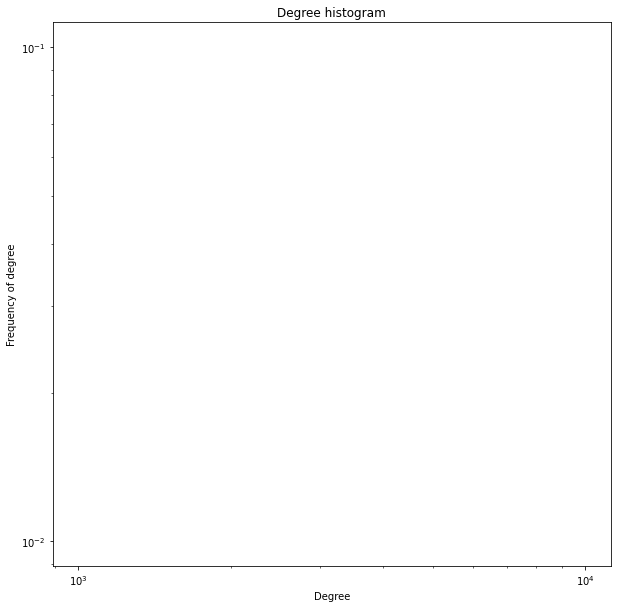

In [138]:
# Demonstrating the scale-free property of our network, explaining the difficult 
f, ax = plt.subplots(figsize=(10, 10))
ax.set(xscale="log", yscale="log")

degree_freq = np.array(nx.degree_histogram(G))
degrees = range(len(degree_freq))
sns.scatterplot(x=degrees, y=degree_freq/degree_freq.sum())


ax.set_title("Degree histogram")
ax.set_xlabel("Degree")
ax.set_ylabel("Frequency of degree")
plt.show()

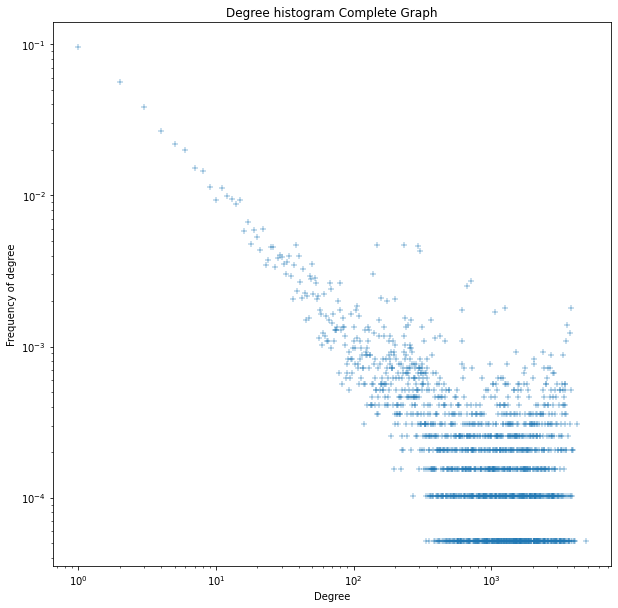

In [310]:
# Demonstrating the scale-free property of our network, explaining the difficult 
f, ax = plt.subplots(figsize=(10, 10))
ax.set(xscale="log", yscale="log")

degree_freqCG = np.array(nx.degree_histogram(CG))
degreesCG = range(len(degree_freqCG))
sns.scatterplot(x=degreesCG, y=degree_freqCG/ degree_freqCG.sum(), marker="+")

ax.set_title("Degree histogram Complete Graph")
ax.set_xlabel("Degree")
ax.set_ylabel("Frequency of degree")
plt.show()

### 1.3 Partitions of network without 0 and 1 degrees

In [44]:
# Use louvain algorithm to find partitions
# running this takes ~3 mins
division = community_louvain.best_partition(G)
print("We have " + str(len(set(division.values()))) + " divisions")

We have 1110 divisions


In [47]:
# Louvain on original graph
division_alt = community_louvain.best_partition(CG)
print("The original graph has " + str(len(set(division_alt.values()))) + " divisions")

The original graph has 880 divisions


In [50]:
# Getting the amount of nodes within each cluster
# All different clusters
different_clst = division.values()
# A dictionary with the cluster as keys and the amount of movies as values
all_clusters = dict(collections.Counter(division.values()))
sorted_clust = dict(sorted(all_clusters.items(), key=lambda x: x[1], reverse=True))
print(sorted_clust)

{9: 1989, 0: 1962, 10: 1838, 4: 1034, 12: 711, 8: 576, 337: 267, 174: 220, 39: 167, 41: 93, 87: 93, 94: 41, 50: 39, 238: 31, 180: 26, 685: 23, 20: 18, 16: 17, 149: 17, 244: 17, 362: 17, 33: 16, 228: 16, 501: 15, 512: 13, 79: 12, 196: 12, 285: 12, 568: 12, 772: 12, 40: 11, 290: 11, 861: 11, 637: 10, 672: 10, 80: 9, 211: 9, 312: 9, 449: 9, 927: 9, 145: 8, 162: 8, 169: 8, 220: 8, 58: 7, 85: 7, 88: 7, 167: 7, 201: 7, 437: 7, 643: 7, 906: 7, 977: 7, 30: 6, 165: 6, 230: 6, 335: 6, 343: 6, 393: 6, 444: 6, 693: 6, 694: 6, 711: 6, 743: 6, 839: 6, 898: 6, 921: 6, 35: 5, 138: 5, 140: 5, 152: 5, 259: 5, 269: 5, 273: 5, 367: 5, 372: 5, 394: 5, 404: 5, 414: 5, 428: 5, 438: 5, 445: 5, 478: 5, 516: 5, 557: 5, 580: 5, 697: 5, 736: 5, 848: 5, 941: 5, 960: 5, 971: 5, 21: 4, 22: 4, 27: 4, 65: 4, 81: 4, 90: 4, 109: 4, 110: 4, 111: 4, 121: 4, 125: 4, 205: 4, 215: 4, 226: 4, 248: 4, 262: 4, 280: 4, 313: 4, 324: 4, 327: 4, 346: 4, 349: 4, 368: 4, 411: 4, 420: 4, 448: 4, 468: 4, 484: 4, 498: 4, 519: 4, 525: 4,

In [51]:
# All the number of movies within the different clusters
freqs = sorted(set(sorted_clust.values()))
print(freqs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 23, 26, 31, 39, 41, 93, 167, 220, 267, 576, 711, 1034, 1838, 1962, 1989]


In [52]:
# We define some large clusters in order to be able to analyse them more closely
# Calculating percentages for clusters that don't have many films doesn't make much sense
# Choosing to take clusers from 50 movies on
large_clusters = [k for k in sorted_clust.keys() if sorted_clust[k] > 50]
print("Number of clusters with over 50 movies:", len(large_clusters))
print("Labels of those large clusters:", large_clusters)

Number of clusters with over 50 movies: 11
Labels of those large clusters: [9, 0, 10, 4, 12, 8, 337, 174, 39, 41, 87]


In [53]:
# Dictionary of movie and cluster to which it belongs, only keeping the ones in large clusters
dict_clst = {k:division[k] for k in division.keys() if division[k] in large_clusters}
print(dict_clst)

{'B000NDFLWG': 0, 'B0001IXT36': 0, 'B000B0WO4O': 0, 'B000BQ5IWS': 0, 'B000069503': 0, 'B0002ZDWGC': 0, 'B000621NRQ': 0, 'B00009PBHJ': 4, 'B000GTJSGC': 174, 'B000HWXOT0': 0, 'B00005OCQQ': 337, 'B00009PBJ5': 4, 'B0002IQNEC': 174, 'B0000C2IXK': 337, 'B0000A02UH': 0, 'B000MAFXQO': 0, 'B00006954J': 0, 'B000JVSUSE': 0, 'B00004YKPT': 8, 'B000OU081M': 0, 'B0002HDXTQ': 4, 'B00004CJQB': 9, 'B000G5SILM': 0, 'B0001L3LUE': 0, 'B000C3L2IO': 0, 'B000GFRIIG': 0, '0767043367': 4, 'B0002849HA': 0, 'B00004NKCT': 10, 'B0007DBJM8': 0, 'B00007JMD8': 10, 'B00074DXFS': 0, 'B001KWB0L0': 0, 'B000K7VHI2': 0, 'B00009ATKE': 9, 'B00329PYGQ': 0, 'B000EHQTQI': 0, 'B00008DDV4': 0, 'B00008DDV3': 0, '6304354738': 9, 'B00007CVSP': 4, 'B000I8NGAK': 0, 'B000G5SILC': 0, 'B00004RR2E': 9, '5553637791': 10, 'B000A7BQVU': 0, 'B00004CI5P': 4, 'B000I5Y8FU': 0, 'B0007LEMQ0': 0, 'B000060MYF': 4, 'B0001LYFKY': 0, 'B000U6YJMO': 0, 'B000O78646': 0, 'B001G43C1S': 0, 'B000GDIBSO': 9, '0767064771': 0, 'B000FBH3W2': 0, 'B00329PYHA': 10, '

In [54]:
# Dictionary of clusters as keys and lists of movies in those clusters as values
clts = {cl: [mv for mv in dict_clst.keys() if dict_clst[mv]==cl] for cl in large_clusters}
clts = dict(sorted(clts.items()))
print(clts)

{0: ['B000NDFLWG', 'B0001IXT36', 'B000B0WO4O', 'B000BQ5IWS', 'B000069503', 'B0002ZDWGC', 'B000621NRQ', 'B000HWXOT0', 'B0000A02UH', 'B000MAFXQO', 'B00006954J', 'B000JVSUSE', 'B000OU081M', 'B000G5SILM', 'B0001L3LUE', 'B000C3L2IO', 'B000GFRIIG', 'B0002849HA', 'B0007DBJM8', 'B00074DXFS', 'B001KWB0L0', 'B000K7VHI2', 'B00329PYGQ', 'B000EHQTQI', 'B00008DDV4', 'B00008DDV3', 'B000I8NGAK', 'B000G5SILC', 'B000A7BQVU', 'B000I5Y8FU', 'B0007LEMQ0', 'B0001LYFKY', 'B000U6YJMO', 'B000O78646', 'B001G43C1S', '0767064771', 'B000FBH3W2', 'B000VKL6ZW', 'B00007GVM0', 'B000ALM40S', 'B002DLB1IO', 'B00443TULY', 'B000JGEXFS', 'B00007K05W', '6305582394', 'B000092T6A', 'B000GNOHGE', 'B00006ADHA', 'B001NG9GZ0', 'B00180R040', 'B0000AKCMB', 'B0000AKCMC', 'B000U95N9O', 'B000U6YJLU', 'B002N7W3IA', 'B001BEK8FQ', 'B0042EJD8A', 'B0047UJBJK', 'B001EUSYHQ', 'B004D6ZDW2', 'B0036WK57C', 'B005D0RD98', 'B0027BOL4Q', 'B000ZN71GS', 'B0002OXVBY', 'B0002IQNF6', '1463116322', 'B0027BOL4G', 'B000K2V7EQ', 'B000U788UM', 'B00181XY6M', '

## Ratio of partitions corresponding to each genre

In [55]:
# Making sets of all films in each genre
#'Action', 'Horror', 'Documentary', 'Musicals', 'Anime & Manga'
Doc = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Documentary'}
Act = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Action'}
Hor = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Horror'}
Mus = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Musicals'}
AnM = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Anime & Manga'}

In [56]:
def lookup(genre):
    """Function taking as input a genre and returning the movie set corresponding to that genre"""
    if genre=='Documentary':
        return Doc
    if genre=='Action':
        return Act
    if genre=='Musicals':
        return Mus
    if genre=='Anime & Manga':
        return AnM
    if genre=='Horror':
        return Hor  

In [57]:
def pct_genre(lst_movies, genre):
    """Takes a genre and a list of movies and returns how much percentage of this one genre can be found in the list"""
    if len(lst_movies)==0:
        return 0
    else:
        per = round(len([mv for mv in lst_movies if mv in genre])/len(lst_movies)*100, 2)
        return per

In [58]:
def pct_cl_genre(clkey, cldict, genre):
    """Takes as input a cluster key, a cluster dictionary and a genre and outputs the percentage of genre within a 
    specific cluster of the dictionary"""
    mvies = cldict[clkey] 
    p = pct_genre(mvies, lookup(genre))
    return p

In [59]:
# Let us try out the last function
pct_cl_genre(4, clts, "Documentary")

26.31

## Results for the percentages in dataframe

In [63]:
# Create an empty dataframe with as columns the different genres and as index the 12 different clusters
cl_df = pd.DataFrame(columns=sorted(list(set(values))), index=list(clts.keys()))
# Adding the percentage values to the dataframe row by row
for i in list(cl_df.index):
    pct = pd.Series({k:pct_cl_genre(i, clts, k) for k in list(cl_df.columns)})
    cl_df.loc[i] = pct
cl_df

,Action,Anime & Manga,Documentary,Horror,Musicals
0,34.51,10.91,34.2,8.97,11.42
4,12.57,11.8,26.31,33.46,15.86
8,25.17,1.74,26.39,35.76,10.94
9,5.43,3.22,28,13.78,49.57
10,6.58,2.5,6.31,81.34,3.26
12,1.55,4.36,79.61,2.53,11.95
39,7.19,0.6,49.7,5.39,37.13
41,23.66,0,13.98,3.23,59.14
87,1.08,96.77,0,2.15,0
174,33.64,2.27,34.09,17.27,12.73


### Additional pie charts for clusters with no genre majority

In [64]:
# Transposing the table to manipulate it more easily
new = cl_df.T
new

,0,4,8,9,10,12,39,41,87,174,337
Action,34.51,12.57,25.17,5.43,6.58,1.55,7.19,23.66,1.08,33.64,32.58
Anime & Manga,10.91,11.8,1.74,3.22,2.5,4.36,0.6,0,96.77,2.27,1.5
Documentary,34.2,26.31,26.39,28,6.31,79.61,49.7,13.98,0,34.09,50.19
Horror,8.97,33.46,35.76,13.78,81.34,2.53,5.39,3.23,2.15,17.27,5.62
Musicals,11.42,15.86,10.94,49.57,3.26,11.95,37.13,59.14,0,12.73,10.11


In [66]:
# Creating a list  of instances where there is no genre majority
i = 0
lst_less = []
for x in list(new.columns):
    if any([y > 50 for y in list(new[x])]):
        i += 1
    else:
        lst_less.append(x)

In [67]:
print("Number of clusters out of 12 where there is a genre majority:", i)
print(f"Percentage of clusters where genre majority exists: {len(lst_less)/len(new[x])/100}%")
print("Clusters where there is no genre majority:", lst_less)

Number of clusters out of 12 where there is a genre majority: 5
Percentage of clusters where genre majority exists: 0.012%
Clusters where there is no genre majority: [0, 4, 8, 9, 39, 174]


In [68]:
keys_name = {name: i for i, name in enumerate(clts.keys())}
def get_index(nm):
    return keys_name[nm]

In [69]:
def make_pie(clster, df):
    name = get_index(clster)
    x = list(df.iloc[name])
    y = list(df.columns)
    colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(x)))
    fig, ax = plt.subplots()
    ax.pie(x, autopct='%1.1f%%', colors=colors, radius=3, center=(4, 4),
           wedgeprops={"linewidth": 1, "edgecolor": "white"})
    ax.legend(labels=y, loc="lower right")
    ax.set_title(f"Cluster {clster}: % per Genre")
    ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
           ylim=(0, 8), yticks=np.arange(1, 8))
    plt.axis('off')
    plt.show()

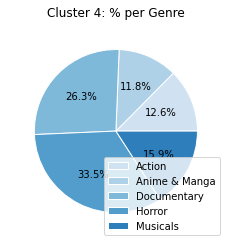

In [70]:
make_pie(4, cl_df)

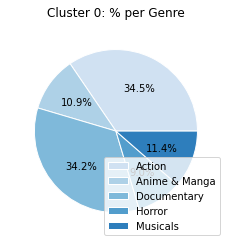

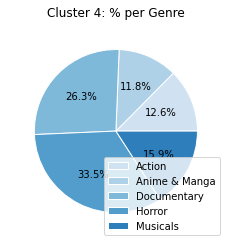

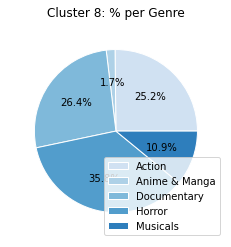

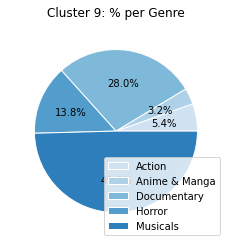

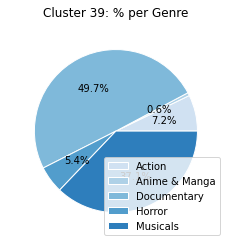

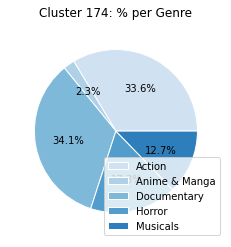

In [71]:
for x in lst_less:
    make_pie(x, cl_df)